In [160]:
import pandas as pd
import numpy as np
import seaborn as sns

from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import pickle


import re
import string
from nltk import word_tokenize

import matplotlib.pyplot as plt
%matplotlib inline  

import warnings
warnings.filterwarnings("ignore")

In [234]:
results = pd.read_csv('results_wiki_100_glove.csv')

In [235]:
results_def = results[(results['augmented']==False) & (results['cut']==False) & (results['lower']==False)]

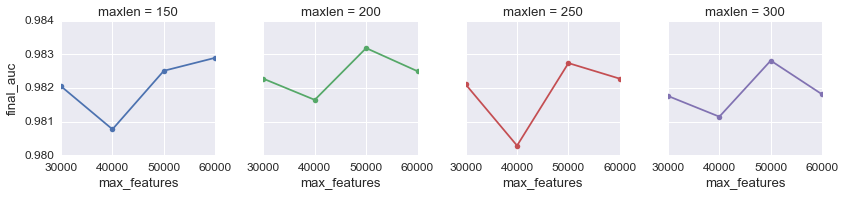

In [238]:
sns.set(style='ticks')
sns.set(font_scale=1.2)
grid = sns.FacetGrid(results_def, col='maxlen', hue='maxlen', col_wrap=4, size=3)
grid.map(plt.plot, 'max_features', 'final_auc', marker='o', ms=5.5)

grid.set(xticks=[30000, 40000, 50000, 60000], yticks=[0.98, 0.981, 0.982, 0.983, 0.984],
         ylim=(0.98, 0.984), xlim=(30000, 60000))
grid.fig.tight_layout(w_pad=1)

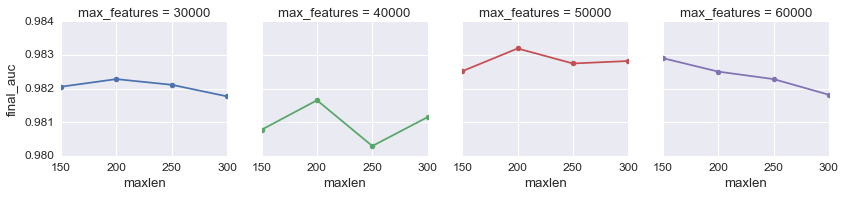

In [239]:
sns.set(style='ticks')
sns.set(font_scale=1.2)
grid = sns.FacetGrid(results_def, col='max_features', hue='max_features', col_wrap=4, size=3)
grid.map(plt.plot, 'maxlen', 'final_auc', marker='o', ms=5.5)
grid.set(xticks=[150, 200, 250, 300], yticks=[0.98, 0.981, 0.982, 0.983, 0.984],
         ylim=(0.98, 0.984), xlim=(150, 300))
grid.fig.tight_layout(w_pad=1)

In [176]:
results_ = results[(results['maxlen']==200) & (results['max_features']==50000)]

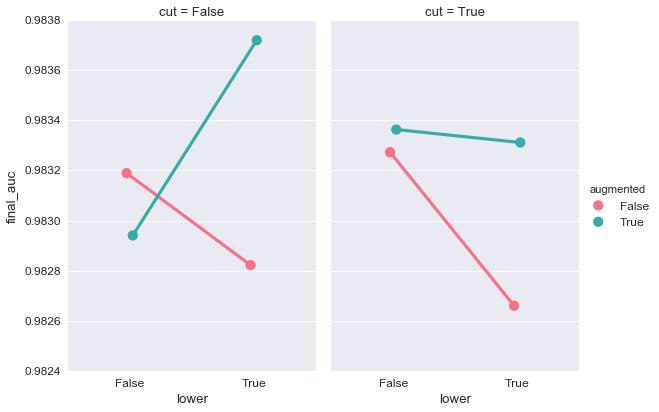

In [240]:
sns.set(font_scale=1.2)
g = sns.factorplot(x='lower', y='final_auc', hue='augmented', col='cut', data=results_, 
                   kind='point', dodge=True, size=6, aspect=.7, palette='husl');

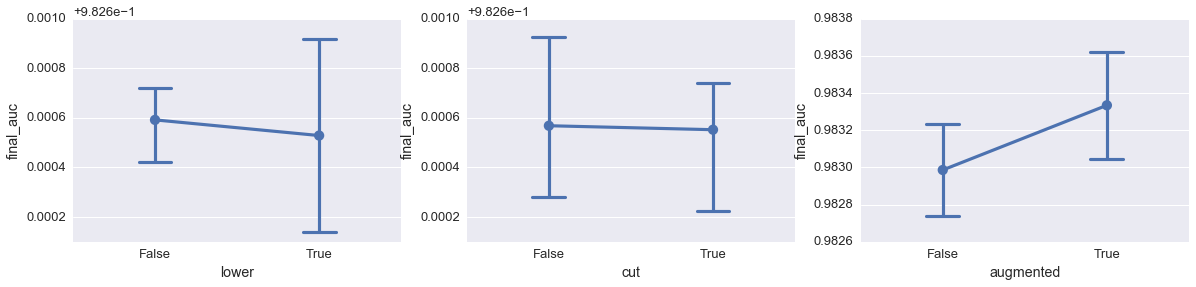

In [242]:
sns.set(font_scale=1.3)
fig, ax =plt.subplots(1,3,figsize=(20,4))
sns.pointplot(x='lower', y='final_auc', data=results_, normed=False, capsize=.2, ax=ax[0]);
sns.pointplot(x='cut', y='final_auc', data=results_, normed=False, capsize=.2, ax=ax[1]);
sns.pointplot(x='augmented', y='final_auc', data=results_, normed=False, capsize=.2, ax=ax[2]);
fig.show()

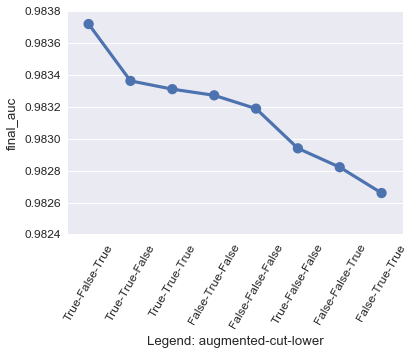

In [243]:
sns.set(font_scale=1.2)
labels = results_['augmented'].astype(str) + '-' + results_['cut'].astype(str) + '-' + results_['lower'].astype(str)
results_['augmented_cut_lower'] = labels
ax = sns.pointplot(x='augmented_cut_lower', y='final_auc', data=results_);
ax.set_xticklabels(rotation=60, labels=labels);
ax.tick_params(labelsize=12);
ax.set(xlabel='Legend: augmented-cut-lower');

In [245]:
results = pd.read_csv('embeddings.csv')

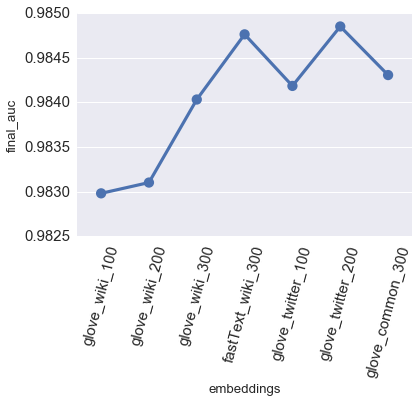

In [246]:
sns.set(font_scale=1.2)
labels = ['glove_wiki_100', 'glove_wiki_200', 'glove_wiki_300', 'fastText_wiki_300', 'glove_twitter_100', 'glove_twitter_200', 'glove_common_300']
ax = sns.pointplot(x='embeddings', y='final_auc', data=results);
ax.set_xticklabels(rotation=75, labels=labels);
ax.tick_params(labelsize=15);

In [306]:
results = pd.read_csv('results_arch.csv')

In [307]:
results_n = results[(results['recurrent_dropout']==0.1) & (results['dropout']==0.1)]

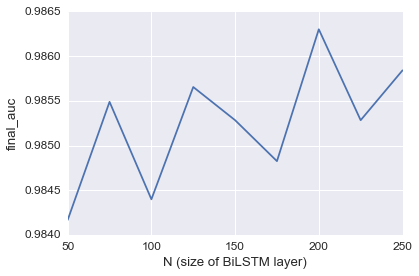

In [308]:
sns.set(font_scale=1.2)
plt.plot(results_n['n'], results_n['final_auc'])
plt.xlabel('N (size of BiLSTM layer)')
plt.ylabel('final_auc');

In [309]:
results_200 = results[(results['n']==200) & (results['pooling']=='global_max') & (results['dropout']!=0)]

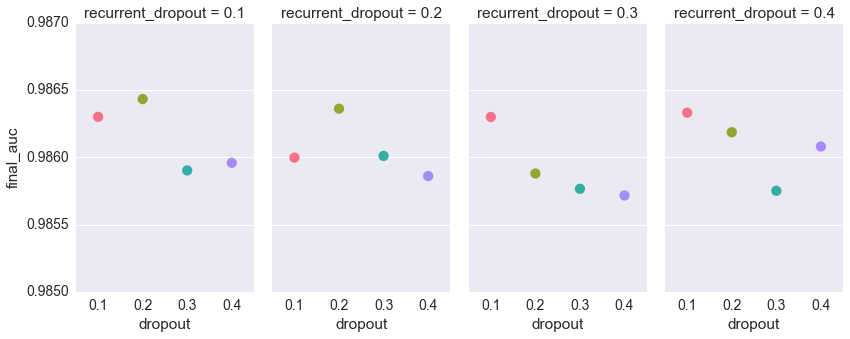

In [310]:
sns.set(font_scale=1.4)
g = sns.factorplot(x='dropout', y='final_auc', col='recurrent_dropout', data=results_200, 
                   size=5, aspect=.6, palette='husl');
g.set(ylim=(0.985,0.987));

In [426]:
baseline = pd.read_csv('baseline.csv')
best_model = results_200[(results_200['recurrent_dropout']==0.1) & (results_200['dropout']==0.2)][baseline.columns]

categories = [x.split('_')[0] for x in baseline.columns[:-1]] + ['all']
metrics = [x.split('_')[1] for x in baseline.columns[:-1]] + ['auc']

In [427]:
baseline = baseline.transpose()
best_model = best_model.transpose()

baseline.columns = ['score']
best_model.columns = ['score']

baseline['model'] = 'baseline'
best_model['model'] = 'solution'

baseline['category'] = categories
baseline['metric'] = metrics

best_model['category'] = categories
best_model['metric'] = metrics

In [428]:
results = pd.concat([baseline, best_model], ignore_index=True)

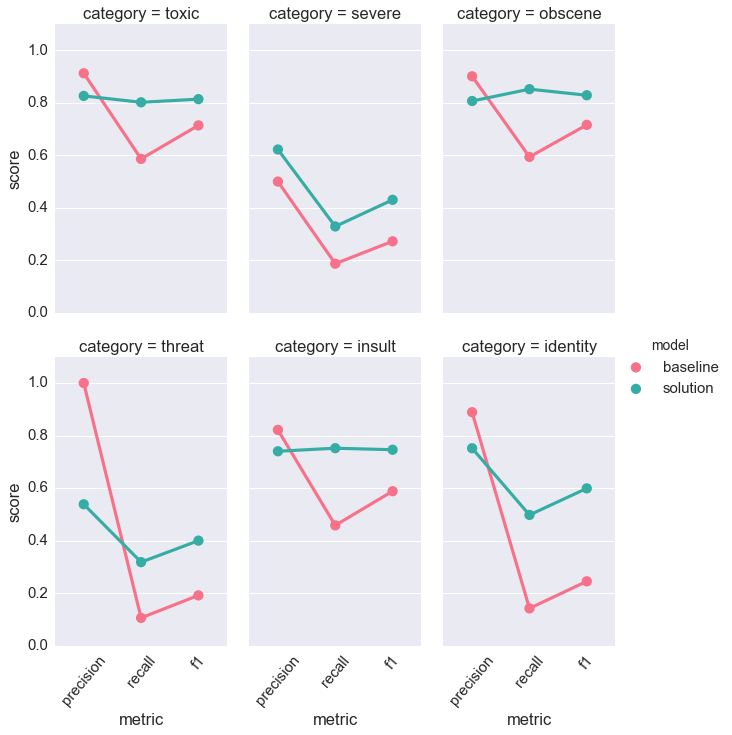

In [429]:
f1 = results[(results['category']!='all') & (results['metric']!='auc')]

sns.set(font_scale=1.5)
ax = sns.factorplot(x='metric',  y='score', hue = 'model', col='category', 
                    col_wrap=3, data=f1, size=5, aspect=0.6, palette='husl');

ax.set_xticklabels(rotation=50, labels=['precision','recall','f1']);
ax.set(ylim=(0,1.1));

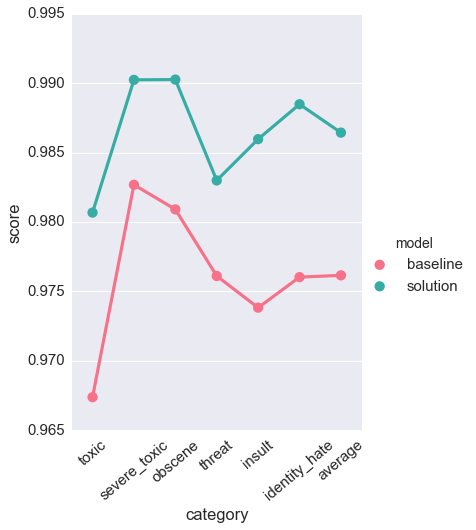

In [437]:
auc = results[results['metric']=='auc']

sns.set(font_scale=1.5)
ax = sns.factorplot(x='category',  y='score', hue = 'model', data=auc, size=7, aspect=0.8, palette='husl');
ax.set_xticklabels(rotation=40, labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate', 'average']);

**PLAYING WITH THE MODEL**

In [178]:
# run this cell to define the functions needed to use the model

# function from learning.ipynb
def get_col_name(maxlen=150, max_features=30000, cut=False, lower=False):
    if lower:
        if cut:
            postfix = 'lower_cut'
        else:
            postfix = 'lower'
    else:
        if cut:
            postfix = 'upper_cut'
        else:
            postfix = 'upper'
    
    name = '{}_{}_{}'.format(maxlen, max_features, postfix)
    return name

ip = r'[\d]+(?:\.[\d]+){3}'
url = r'http\:[^\s]+'
digit = r'[\d]+'
user = r'[Uu]ser\:[^\s]+'

# function from preprocessing.ipynb
def clean_text(text): 
    text = re.sub(ip,'',text)
    text = re.sub(url,'',text)  
    text = re.sub(digit,'',text)
    text = re.sub(user,'',text)
    text = text.translate(str.maketrans('','',string.punctuation))       
    tokens = word_tokenize(text)   
    tokens = [x for x in tokens if len(x) > 1]
    joined = str(' '.join(tokens))
    return joined

# helper function to transform user text into ready to feed to the model input
def process_text(text, tokenizer, maxlen=200, verbose=0):
    text = clean_text(text)
    if verbose:
        print('Preprocessed text:\n {}\n'.format(text))
    tokenized = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(tokenized, maxlen=maxlen)
    return padded[0].reshape(1,maxlen)  

# helper function to get prediction
def predict_category(text, model, th=0.5):
    preds = model.predict(text).tolist()[0]
    preds = [p>th for p in preds]
    preds = list(zip(categories, preds))
    preds = [p[0] for p in preds if p[1] == True]
    return preds

def am_i_toxic(text, model, tokenizer, th=0.5, verbose=0):
    text = process_text(text.lower(), tokenizer, verbose=verbose)
    preds = predict_category(text, model, th=th)
    print('Threshold: {}'.format(th))
    if len(preds) > 0:
        print('Toxic categores: {}'.format(', '.join(preds)))
    else:
        print('The text is not toxic')    

In [107]:
# run this cell to load the model and the tokenizer

model = load_model('models/final_model.h5')

# loading tokenizer with optimal parameters
categories = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

maxlen = 200
max_features = 50000
lower = True
cut = False 
name = get_col_name(maxlen, max_features, cut, lower)
TOKENIZER_PICKLE = 'pickles/tokenizer_{}.pickle'.format(name)
with open(TOKENIZER_PICKLE, 'rb') as handle:
    tokenizer = pickle.load(handle)
    
assert(tokenizer.__dict__['num_words'] == max_features)

In [188]:
#Put your text into the text varibale to play with the model 
text = 'What a bunch of nonsense. You are trying to stir up trouble.'
preds = am_i_toxic(text, model, tokenizer, th=0.8, verbose=1)

Preprocessed text:
 what bunch of nonsense you are trying to stir up trouble

Threshold: 0.8
The text is not toxic


In [189]:
text = 'What a bunch of crap. You are trying to stir up trouble.'
preds = am_i_toxic(text, model, tokenizer, th=0.5, verbose=1)

Preprocessed text:
 what bunch of crap you are trying to stir up trouble

Threshold: 0.5
Toxic categores: toxic, obscene


In [190]:
text = 'What a bunch of shit. You are trying to stir up trouble.'
preds = am_i_toxic(text, model, tokenizer, th=0.5, verbose=1)

Preprocessed text:
 what bunch of shit you are trying to stir up trouble

Threshold: 0.5
Toxic categores: toxic, obscene


In [191]:
text = 'What a bunch of nonsense. You are trying to skrew things up.'
preds = am_i_toxic(text, model, tokenizer, th=0.5, verbose=1)

Preprocessed text:
 what bunch of nonsense you are trying to skrew things up

Threshold: 0.5
Toxic categores: toxic


In [192]:
text = 'What a bunch of nonsense. You are trying to fuck everything up.'
preds = am_i_toxic(text, model, tokenizer, th=0.1, verbose=1)

Preprocessed text:
 what bunch of nonsense you are trying to fuck everything up

Threshold: 0.1
Toxic categores: toxic, obscene, insult


In [193]:
text = 'All this crap did not just happen yesterday. It has been building for decades. \
        Being a passive pussy wont help prevent a war, being firm and able to talk to each other just might. \
        And forget that prophecy BS.'
preds = am_i_toxic(text, model, tokenizer, th=0.5, verbose=1)

Preprocessed text:
 all this crap did not just happen yesterday it has been building for decades being passive pussy wont help prevent war being firm and able to talk to each other just might and forget that prophecy bs

Threshold: 0.5
Toxic categores: toxic, obscene


In [184]:
text = 'All this shit did not just happen yesterday. It has been building for decades. \
        Being a passive pussy wont help prevent a war, being firm and able to talk to each other just might. \
        And forget that prophecy BS.'
preds = am_i_toxic(text, model, tokenizer, th=0.5)

Threshold: 0.5
Toxic categores: toxic, obscene


In [185]:
text = 'All this crap did not just happen yesterday. It has been building for decades. \
        Being passive wont help prevent a war, being firm and able to talk to each other just might. \
        And forget that prophecy BS.'
preds = am_i_toxic(text, model, tokenizer, th=0.5)

Threshold: 0.5
Toxic categores: toxic


In [186]:
text = 'All this crap did not just happen yesterday. It has been building for decades. \
        Do not be a pussy, being firm and able to talk to each other just might prevent the war. \
        And forget that prophecy BS.'
preds = am_i_toxic(text, model, tokenizer, th=0.5)

Threshold: 0.5
Toxic categores: toxic, obscene


In [187]:
text = 'All this did not just happen yesterday. It has been building for decades. \
        Being passive wont, being firm and able to talk to each other just might prevent the war. \
        And forget that prophecy BS.'
preds = am_i_toxic(text, model, tokenizer, th=0.5)

Threshold: 0.5
The text is not toxic
